# Bayesian Linear Regression

In this notebook was created by Martin Engqvist in 2021 with the goal to implement and test ideas for Bayesian linear regression models. Inspiration for the modified least squares was drawn from page 66 of the book "A Bayesian Tutorial" by By D. S. Sivia and J. Skilling (ISBN 978-0-19-856831-5). The use of basis functions (fixed non-linear functions of the input variables) was inspired by formula 3.2 from page 138 of the book "Pattern recognition" by C. M. Bishop (ISBN 978-1-4939-3843-8). Additional help with implementing the model in Pyro was drawn from http://pyro.ai/examples/bayesian_regression.html.

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.
This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.
You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.

In [1]:
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import beta
import math
import scipy

import random 

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

import pyro
import pyro.infer
import pyro.optim
import pyro.distributions as dist
from pyro.nn import PyroModule
from pyro import param
from pyro.poutine import trace
from pyro import condition
from pyro.optim import Adam, ClippedAdam
from pyro.infer import SVI, Trace_ELBO, HMC, MCMC, NUTS
from pyro.contrib.autoguide import AutoDiagonalNormal, AutoMultivariateNormal, AutoContinuous, AutoGuide

import torch
import torch.nn as nn

import resreg

from pprint import pprint


from tqdm import tqdm

from os.path import join, exists, basename

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# for CI testing
smoke_test = ('CI' in os.environ)
pyro.set_rng_seed(1)

assert issubclass(PyroModule[torch.nn.Linear], torch.nn.Linear)
assert issubclass(PyroModule[torch.nn.Linear], PyroModule)

display('pyro version: {}'.format(pyro.__version__))

pyro.set_rng_seed(101)

'pyro version: 1.4.0'

## Linear models

### Setup function to generate data

In [2]:
def get_x(y, pieces=10):
    
    X = []
    for idx in range(pieces-1):
        X.append(random.uniform(0, y-sum(X)))
    X.append(y-sum(X))
                  
    # randomize the order
    random.shuffle(X)
                  
    # devide by the weights (since I know the "true" function)
    X = np.array(X) / np.arange(1, pieces+1, 1)
    
    return X.tolist()


def generate_data(n=20, ymin=10, ymax=100, sigma=5):
    X = []
    y_obs = []
    y_true = []
    stdevs = []
    
    for s in range(n):
        # sample y three times (to simulate measurements)
        mu = np.random.choice(np.arange(ymin, ymax))
        y_true.append(mu)
        
        measured_y = -1
        while measured_y < 0:
            measured_y = pyro.sample('y', dist.Normal(mu, sigma))

        # add y and stdev to data
        y_obs.append(measured_y.item())
        stdevs.append(sigma)

        # find X to match this y
        # y is a linear combination of x
        # lm = x1*1 + x2*2 + x3*3 + x4*4 + x5*5 + 2.5 = y
        X.append(get_x(mu-2.5))

    df = pd.DataFrame({'y_obs':y_obs, 'y_true':y_true, 'stdev':stdevs})
    df = df.join(pd.DataFrame(X, columns=['x{}'.format(i) for i in range(1, len(X[0])+1)]) )
    
    return df



data_filepath = join('data', 'linear_model_balanced.tsv')
if exists(data_filepath):
    df = pd.read_csv(data_filepath, sep='\t', index_col=0)
    
else:
    # A set of data with low error
    df_low = generate_data(n=10, ymin=5, ymax=100, sigma=5)

    # A set of data with high error
    df_high = generate_data(n=40, ymin=5, ymax=100, sigma=30)

    # combine
    df = df_low.append(df_high)

    # randomize 
    df = df.sample(frac=1).reset_index(drop=True)
    
    # save it
    df.to_csv(data_filepath, sep='\t')


# prepare splits
train, test = train_test_split(df, test_size=0.2, random_state=42)

X_train = train.drop(['y_obs', 'y_true', 'stdev'], axis=1).to_numpy()
y_train = train.y_obs.to_numpy()
stdev_train = train.stdev.to_numpy()

X_test = test.drop(['y_obs', 'y_true', 'stdev'], axis=1).to_numpy()
y_test = test.y_true.to_numpy()

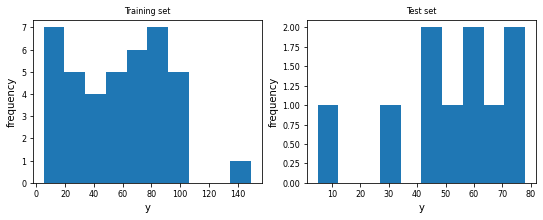

In [3]:
fig, ax = plt.subplots(1, 2, figsize=(9,3))

ax[0].hist(y_train)
ax[0].set(xlabel="y",
          ylabel="frequency",
          title="Training set")

ax[1].hist(y_test)
ax[1].set(xlabel="y",
          ylabel="frequency",
          title="Test set")

plt.show()

## Fit a classical linear model

In [4]:
# data to tensor
scaler = StandardScaler().fit(X_train)

X_train = torch.tensor(scaler.transform(X_train))
y_train = torch.tensor(y_train)
stdev_train = torch.tensor(stdev_train)

In [5]:
class LinearModelMSE(object):
    """A linear model fitted by MSE.
    """
    def __init__(self, in_features, out_features, bias=True):
        
        self.in_features = in_features
        self.out_features = out_features

        self.use_bias = bias
 
        # set the model
        self.model = PyroModule[torch.nn.Linear](in_features, out_features).double()

    def fit(self, X, y, lr=0.05, steps=2000):
        """Fit model to data
        """
        pyro.clear_param_store()

        # set up optimizer and loss function
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)
        self.loss_fn = torch.nn.MSELoss(reduction='sum')

        for j in range(steps):
            # initialize gradients to zero
            self.optimizer.zero_grad()
            
            # run the model forward on the data
            y_pred = self.model(X).squeeze(-1)

            # calculate the mse loss
            loss = self.loss_fn(y_pred, y_train)

            # backpropagate
            loss.backward()

            # take a gradient step
            self.optimizer.step()            
            
            if j % 500 == 0:
                print('[epoch:{}], loss:{:.2f}'.format(j, loss.item()))
        print('[epoch:{}], loss:{:.2f}'.format(j, loss))
        
        
    def predict(self, X):
        """Predict on new data
        """
        self.model.requires_grad_(False)
        
        return self.model(X).detach().cpu().numpy().ravel()

    
    def get_params(self):
        """Get all the model parameters
        """
        self.model.requires_grad_(False)

        # Inspect learned parameters
        params = {}
        for name, param in self.model.named_parameters():
            params[name] = param.data.numpy()

        return params

    
mse_model = LinearModelMSE(X_train.shape[1], 1, bias=True)
mse_model.fit(X_train, y_train, lr=0.05, steps=5000)

display(mse_model.get_params())

[epoch:0], loss:181970.54
[epoch:500], loss:66816.95
[epoch:1000], loss:29062.26
[epoch:1500], loss:16605.23
[epoch:2000], loss:13921.96
[epoch:2500], loss:13601.51
[epoch:3000], loss:13583.70
[epoch:3500], loss:13583.33
[epoch:4000], loss:13583.33
[epoch:4500], loss:13583.33
[epoch:4999], loss:13583.33


{'weight': array([[ 9.3721019 ,  2.06419485, 10.74267392, 12.05485684,  4.19615811,
         10.85318899, 13.77688952, 12.89318644,  8.92592032, 12.17135815]]),
 'bias': array([58.92980322])}

## Fit a classical linear model using a loss metric that accounts for measurement error
A robust linear model which accounts for the standard deviation in y when fitting. According to page 66 in "Data Analysis - A Bayesian Tutorial" (ISBN 978-0-19-856831-5).

In [6]:
class LinearModelErrorsMSE(LinearModelMSE):
    """
    """
    def __init__(self, in_features, out_features, bias=True):
        super().__init__(in_features, out_features)
        
        self.in_features = in_features
        self.out_features = out_features

        self.use_bias = bias
 
        # set the model
        self.model = PyroModule[torch.nn.Linear](in_features, out_features).double()
        
    def fit(self, X, y, y_errors, lr=0.05, steps=2000):
        """Fit model to data
        """
        pyro.clear_param_store()

        # set up optimizer and loss function
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)
        self.loss_fn = torch.nn.MSELoss(reduction='none')

        for j in range(steps):
            # initialize gradients to zero
            self.optimizer.zero_grad()
            
            # run the model forward on the data
            y_pred = self.model(X).squeeze(-1)

            # calculate the mse loss
            loss = self.loss_fn(y_pred, y_train)
            
            # for each sample, divide the loss by its measurement error
            loss = loss/y_errors
            loss = loss.sum()

            # backpropagate
            loss.backward()

            # take a gradient step
            self.optimizer.step()            
            
            if j % 500 == 0:
                print('[epoch:{}], loss:{:.2f}'.format(j, loss.item()))
        print('[epoch:{}], loss:{:.2f}'.format(j, loss))
        

mse_model_errors = LinearModelErrorsMSE(X_train.shape[1], 1, bias=True)
mse_model_errors.fit(X_train, y_train, stdev_train, lr=0.05, steps=5000)

display(mse_model_errors.get_params())

[epoch:0], loss:12510.45
[epoch:500], loss:3296.78
[epoch:1000], loss:1399.89
[epoch:1500], loss:735.33
[epoch:2000], loss:583.45
[epoch:2500], loss:564.02
[epoch:3000], loss:562.84
[epoch:3500], loss:562.81
[epoch:4000], loss:562.81
[epoch:4500], loss:562.81
[epoch:4999], loss:562.81


{'weight': array([[12.37903161,  4.72164214, 12.67716509, 12.7760833 ,  5.39815572,
         14.2226243 , 15.0108545 ,  9.53469744,  9.84271773, 12.73489655]]),
 'bias': array([55.26636069])}

## Fit a hierarchical Bayesian model, which models the measurement error

**Setup the model**
To make the model robust I do not use the Gaussian distribution, but rather the StudentT distribution. This leads to robustness against outliers. The additional parameter nu (which describes the curve shape) needs to be estimated. See, for example, https://solomonkurz.netlify.app/post/robust-linear-regression-with-the-robust-student-s-t-distribution/

In [7]:
class BayesianLinearModel(nn.Module):
    """A hierarchical Bayesian linear model which accounts for measurement error in y.
    """
    
    def __init__(self, in_features, out_features, bias=True, non_linear=False):
        super().__init__()
        
        self.in_features = in_features
        self.out_features = out_features

        self.use_bias = bias
        self.non_linear = non_linear
      
    def model(self, X, y=None, y_errors=None):
        '''A bayesian linear model which accounts for errors in y
        when estimating the hidden variables.
        '''
        # initialize the bias
        if self.use_bias is True:
            bias = pyro.sample('bias', dist.Normal(0.0, 10.0)).double()

        # initialize the weights for each of the features
        with pyro.plate('weight_plate', X.shape[1]):
            weight = pyro.sample('weight', dist.Normal(0.0, 10.0)).double()
            
            # initialize exponents of X (for non-linearity)
            if self.non_linear is True:
                exponents = pyro.sample('exponents', dist.TransformedDistribution(
                                dist.FoldedDistribution(dist.Normal(loc=0.0, scale=10.0/100)),
                                dist.transforms.AffineTransform(loc=1.0, scale=1.0))).double()
                
        # smple nu, which describes the shape of the t-distribution
        shape = pyro.sample('shape', dist.LogNormal(10.0, 1.0)).double()

        with pyro.plate('observed_data', X.shape[0]):

            # sample distributions to make predictions for y
            if self.use_bias is True and self.non_linear is False:
                mu = bias + X.matmul(weight)
                
            elif self.use_bias is False and self.non_linear is False:
                mu = X.matmul(weight)
                
            elif self.use_bias is True and self.non_linear is True:
                mu = bias + (torch.sign(X) * torch.pow(torch.abs(X), exponents)).matmul(weight)
                
            elif self.use_bias is False and self.non_linear is True:
                mu = (torch.sign(X) * torch.pow(torch.abs(X), exponents)).matmul(weight)
                
            else:
                raise ValueError

            # compare with the observed data
            if y_errors is None:
                pyro.sample('obs', dist.StudentT(df=torch.ones(X.shape[0]) * shape, loc=mu, scale=0.0001), obs=y)
            else:
                pyro.sample('obs', dist.StudentT(df=torch.ones(X.shape[0]) * shape, loc=mu, scale=y_errors), obs=y)

    def guide(self, X, y=None, y_errors=None, weights=None):
        """The model guide
        """
        # initialize the bias
        if self.use_bias is True:
            bias_mu = torch.rand(1)
            bias_sigma = torch.rand(1)
            bias_mu_param = pyro.param("bias_mu", bias_mu)
            bias_sigma_param = pyro.param("bias_sigma", bias_sigma, constraint=dist.constraints.positive)
            bias = pyro.sample('bias', dist.Normal(loc=bias_mu_param, scale=bias_sigma_param).independent(1))

        # initialize the weights for each of the features
        weight_mu = torch.rand(X.shape[1])
        weight_sigma = torch.rand(X.shape[1])
        weight_mu_param = pyro.param("weight_mu", weight_mu)
        weight_sigma_param = pyro.param("weight_sigma", weight_sigma, constraint=dist.constraints.positive)
        weight = pyro.sample('weight', dist.Normal(loc=weight_mu_param, scale=weight_sigma_param).independent(1))

        # initialize exponents of X (for non-linearity)
        if self.non_linear is True:
            exponents_mu = torch.zeros(X.shape[1])
            exponents_sigma = torch.ones(X.shape[1]) * 10
            exponents_mu_param = pyro.param("exponents_mu", exponents_mu, constraint=dist.constraints.positive)
            exponents_sigma_param = pyro.param("exponents_sigma", exponents_sigma, constraint=dist.constraints.positive)
            exponents = pyro.sample('exponents', dist.TransformedDistribution(
                                dist.FoldedDistribution(dist.Normal(loc=exponents_mu_param, scale=exponents_sigma_param/100)),
                                dist.transforms.AffineTransform(loc=1.0, scale=1.0)).independent(1))
                 
        # initialize global nu shape parameter
        shape_loc = torch.rand(1)
        shape_scale = torch.rand(1)
        shape_loc_param = pyro.param("shape_loc", shape_loc, constraint=dist.constraints.positive)
        shape_scale_param = pyro.param("shape_scale", shape_scale, constraint=dist.constraints.positive)
        shape = pyro.sample('shape', dist.LogNormal(shape_loc_param, shape_scale_param))
                
    def fit(self, X, y, y_errors, weights=None, lr=0.01, steps=2000):
        """Fit model using stochastic variational inference (SVI)
        """
        # Clear all the parameter store
        pyro.clear_param_store()

        self.optimizer = ClippedAdam({"lr": lr})
        svi = SVI(model=self.model, guide=self.guide, optim=self.optimizer, loss=Trace_ELBO())

        for i in range(steps):
            loss = svi.step(X, y, y_errors)
            if i % 500 == 0:
                print('[epoch:{}], loss:{:.2f}'.format(i, loss))
        print('[epoch:{}], loss:{:.2f}'.format(i, loss))
        
    def predict(self, X, return_std=False):
        """Predict on new data.
        """
        
        # define sites to sample
        if self.use_bias is True and self.non_linear is False:
            predictive = pyro.infer.Predictive(self.model, guide=self.guide, num_samples=500,
                                return_sites=("bias", "weight", "shape", "obs"))

        elif self.use_bias is False and self.non_linear is False:
            predictive = pyro.infer.Predictive(self.model, guide=self.guide, num_samples=500,
                                return_sites=("weight", "shape", "obs"))

        elif self.use_bias is True and self.non_linear is True:
            predictive = pyro.infer.Predictive(self.model, guide=self.guide, num_samples=500,
                                return_sites=("bias", "weight", "exponents", "shape", "obs"))

        elif self.use_bias is False and self.non_linear is True:
            predictive = pyro.infer.Predictive(self.model, guide=self.guide, num_samples=500,
                                return_sites=("weight", "exponents", "shape", "obs"))
        
        # make the predictions
        self.samples = predictive(X, y=None, y_errors=None)
        
        # get teh average and return
        y_hat = self.samples['obs'].mean(axis=0).detach().numpy()
        std = self.samples['obs'].mean(axis=0).detach().numpy()
        
        if return_std is True:
            return y_hat, std
        else:
            return y_hat
        
    def get_samples(self):
        """Return all the sampled sites
        """
        return self.samples       
        
    def get_params(self, quantiles=False):
        """Get all the model parameters
        """

        if quantiles is False:
            params = {}
            for name, value in pyro.get_param_store().items():
                params[name] = pyro.param(name)
        else:
            pass

        return params
    
#         return self.guide.quantiles([0.25, 0.5, 0.75])
    
    
# stdev_train
bayesian_model = BayesianLinearModel(X_train.shape[1], y_train.shape[0], bias=True, non_linear=False)
bayesian_model.fit(X_train, y_train, stdev_train, steps=5000, lr=0.1)

display(bayesian_model.get_params())

[epoch:0], loss:344.12
[epoch:500], loss:255.34
[epoch:1000], loss:206.01
[epoch:1500], loss:208.61
[epoch:2000], loss:211.02
[epoch:2500], loss:205.55
[epoch:3000], loss:209.90
[epoch:3500], loss:206.37
[epoch:4000], loss:204.14
[epoch:4500], loss:208.89
[epoch:4999], loss:206.05


{'bias_mu': tensor([48.1165], requires_grad=True),
 'bias_sigma': tensor([2.0454], grad_fn=<AddBackward0>),
 'weight_mu': tensor([13.4382,  2.7378, 13.7115,  8.3235,  4.9922, 15.7065, 14.4428, 10.3318,
         11.3460, 11.7126], requires_grad=True),
 'weight_sigma': tensor([1.3195, 2.9904, 0.9213, 3.1240, 3.5449, 1.1105, 4.0480, 1.1442, 1.2285,
         3.7518], grad_fn=<AddBackward0>),
 'shape_loc': tensor([9.6955], grad_fn=<AddBackward0>),
 'shape_scale': tensor([0.8422], grad_fn=<AddBackward0>)}

## Predict on test set and compare

In [8]:
# data to tensor
X_test = torch.tensor(scaler.transform(X_test))
y_test = torch.tensor(y_test)

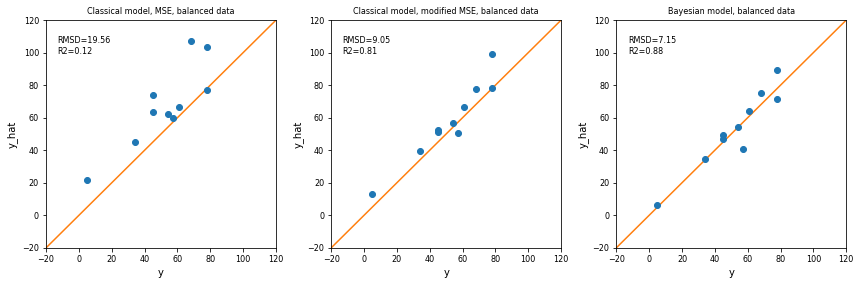

In [9]:
# predict
yhat_classical = mse_model.predict(X_test)
yhat_errors = mse_model_errors.predict(X_test)
yhat_bayes = bayesian_model.predict(X_test)

# calculate rmsd and r2
rmsd_classical = mean_squared_error(y_true=y_test, y_pred=yhat_classical, sample_weight=None, squared=False)
r2_classical = r2_score(y_true=y_test, y_pred=yhat_classical, sample_weight=None)

rmsd_errors = mean_squared_error(y_true=y_test, y_pred=yhat_errors, sample_weight=None, squared=False)
r2_errors = r2_score(y_true=y_test, y_pred=yhat_errors, sample_weight=None)

rmsd_bayes = mean_squared_error(y_true=y_test, y_pred=yhat_bayes, sample_weight=None, squared=False)
r2_bayes = r2_score(y_true=y_test, y_pred=yhat_bayes, sample_weight=None)

# plot the predictions
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4), sharey=False)

ax[0].errorbar(y_test.numpy(), yhat_classical, fmt="o")
ax[0].plot([0, 1], [0, 1], transform=ax[0].transAxes)
ax[0].text(x=0.05, y=0.90, s='RMSD={:.2f}'.format(rmsd_classical), transform=ax[0].transAxes)
ax[0].text(x=0.05, y=0.85, s='R2={:.2f}'.format(r2_classical), transform=ax[0].transAxes)
ax[0].set(xlabel="y",
          ylabel="y_hat",
          title="Classical model, MSE, balanced data",
          xlim=(-20, 120),
          ylim=(-20, 120))

ax[1].errorbar(y_test.numpy(), yhat_errors, fmt="o")
ax[1].plot([0, 1], [0, 1], transform=ax[1].transAxes)
ax[1].text(x=0.05, y=0.90, s='RMSD={:.2f}'.format(rmsd_errors), transform=ax[1].transAxes)
ax[1].text(x=0.05, y=0.85, s='R2={:.2f}'.format(r2_errors), transform=ax[1].transAxes)
ax[1].set(xlabel="y",
          ylabel="y_hat",
          title="Classical model, modified MSE, balanced data",
          xlim=(-20, 120),
          ylim=(-20, 120))

ax[2].errorbar(y_test.numpy(), yhat_bayes, fmt="o")
ax[2].plot([0, 1], [0, 1], transform=ax[2].transAxes)
ax[2].text(x=0.05, y=0.90, s='RMSD={:.2f}'.format(rmsd_bayes), transform=ax[2].transAxes)
ax[2].text(x=0.05, y=0.85, s='R2={:.2f}'.format(r2_bayes), transform=ax[2].transAxes)
ax[2].set(xlabel="y",
          ylabel="y_hat",
          title="Bayesian model, balanced data",
          xlim=(-20, 120),
          ylim=(-20, 120))

plt.tight_layout()
plt.show()

Observations: The outcome depends on the dataset and learning rates. With many samples the models tend to perform similarly, even with the Bayesian model being slightly worse. If learning rate is too low (or steps too few) the Bayesian model does not do as well as the others, it is also slower. But with the right parameters it's clearly the best one.

# Incorporating weighting of samples
Oftentimes the datasets are skewed and many more samples exist from one part of the distribution than from other parts. Here I want to modify the loss functions so that I can pass a weight parameter (between 0.0 and 1.0) such that over-represented samples can be down-weighted to get a better overall fit of the model.

## Make unbalanced train and test sets

In [10]:
data_filepath = join('data', 'linear_model_un-balanced.tsv')
if exists(data_filepath):
    df = pd.read_csv(data_filepath, sep='\t', index_col=0)
    
else:
    # A set of data with low error
    df_low = generate_data(n=10, ymin=10, ymax=100, sigma=5)

    # A set of data with high error
    df_high = generate_data(n=30, ymin=30, ymax=100, sigma=30)
    
    # Add even more low error data toward the low range
    df_low_extra = generate_data(n=20, ymin=25, ymax=35, sigma=5)
    
    # Add even more high error data toward the low range
    df_high_extra = generate_data(n=300, ymin=30, ymax=35, sigma=30)
    
    # combine
    df = df_low.append([df_high, df_low_extra, df_high_extra])

    # randomize 
    df = df.sample(frac=1).reset_index(drop=True)
    
    # save it
    df.to_csv(data_filepath, sep='\t')

# # compute the relevance
# relevance = relevance_pdf1 = resreg.pdf_relevance(df.y, bandwidth=1.0)

# # select a fraction of the indexes
# test_indexes = np.random.choice(df.index, size=int(df.shape[0]*0.1), 
#                  replace=False, 
#                  p=relevance/relevance.sum(axis=0, keepdims=1))


# split data into bins and get an equal number of samples from each
bins = np.arange(30, 74, 15)
train_indices, test_indices = resreg.uniform_test_split(df.index, df.y_true, bins=bins,
                                        bin_test_size=0.5, verbose=True,
                                        random_state=1234)

# make train test splits
test = df.iloc[test_indices]
train = df.iloc[train_indices]

# prepare splits
X_train = train.drop(['y_obs', 'y_true', 'stdev'], axis=1).to_numpy()
y_train = train.y_obs.to_numpy()
stdev_train = train.stdev.to_numpy()

X_test = test.drop(['y_obs', 'y_true', 'stdev'], axis=1).to_numpy()
y_test = test.y_true.to_numpy()



   bin range train size test size
      y < 30         59         3
 30 ≤ y < 45         57         3
 45 ≤ y < 60          3         3
      y ≥ 60          9         3
       TOTAL        128        12




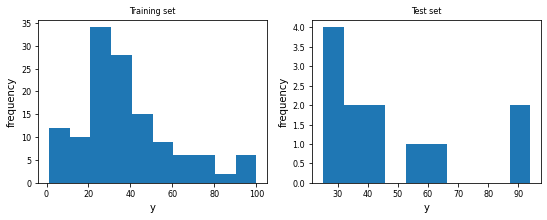

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(9,3))

ax[0].hist(y_train)
ax[0].set(xlabel="y",
          ylabel="frequency",
          title="Training set")

ax[1].hist(y_test)
ax[1].set(xlabel="y",
          ylabel="frequency",
          title="Test set")

plt.show()

## Assign weights for the samples

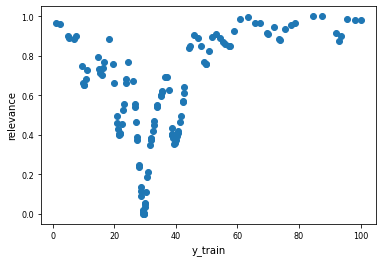

In [12]:
weights = relevance_pdf1 = resreg.pdf_relevance(y_train, bandwidth=1.0)

plt.scatter(y_train, weights, label='bandwidth=5.0')
plt.xlabel('y_train')
plt.ylabel('relevance')
plt.show()

## Train regular model on skewed data

In [13]:
# data to tensor
scaler = StandardScaler().fit(X_train)

X_train = torch.tensor(scaler.transform(X_train))
y_train = torch.tensor(y_train)
stdev_train = torch.tensor(stdev_train)

In [14]:
mse_model = LinearModelMSE(X_train.shape[1], 1, bias=True)
mse_model.fit(X_train, y_train, lr=0.05, steps=5000)

display(mse_model.get_params())

[epoch:0], loss:251775.62
[epoch:500], loss:78612.93
[epoch:1000], loss:43086.21
[epoch:1500], loss:39181.52
[epoch:2000], loss:39031.24
[epoch:2500], loss:39029.69
[epoch:3000], loss:39029.68
[epoch:3500], loss:39029.68
[epoch:4000], loss:39029.68
[epoch:4500], loss:39029.68
[epoch:4999], loss:39029.68


{'weight': array([[7.68792381, 5.3003006 , 6.01540512, 7.6584653 , 5.32953874,
         6.66869142, 5.75654513, 5.99197088, 6.33207607, 5.82676457]]),
 'bias': array([38.47759267])}

## Modify the linear model to accept sample weights

In [15]:
class LinearModelErrorsWeightsMSE(LinearModelMSE):
    """
    """
    def __init__(self, in_features, out_features, bias=True):
        super().__init__(in_features, out_features)
        
    def fit(self, X, y, y_errors, weights, lr=0.05, steps=2000):
        """Fit model to data
        """
        # set up optimizer and loss function
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)
        self.loss_fn = torch.nn.MSELoss(reduction='none')

        for j in range(steps):
            # initialize gradients to zero
            self.optimizer.zero_grad()
            
            # run the model forward on the data
            y_pred = self.model(X).squeeze(-1)

            # calculate the mse loss
            loss = self.loss_fn(y_pred, y_train)
            
            # for each sample, divide the loss by its measurement error and multiply by sample weight
            loss = loss/y_errors
            loss = loss * weights
            loss = loss.sum()

            # backpropagate
            loss.backward()

            # take a gradient step
            self.optimizer.step()            
            
            if j % 500 == 0:
                print('[epoch:{}], loss:{:.2f}'.format(j, loss.item()))
        print('[epoch:{}], loss:{:.2f}'.format(j, loss))
        

mse_model_errors_weights = LinearModelErrorsWeightsMSE(X_train.shape[1], 1, bias=True)
mse_model_errors_weights.fit(X_train, y_train, 
                             stdev_train, 
                             weights=torch.tensor(weights), 
                             lr=0.05, 
                             steps=5000)

display(mse_model_errors_weights.get_params())

[epoch:0], loss:11706.96
[epoch:500], loss:2679.49
[epoch:1000], loss:1312.55
[epoch:1500], loss:1085.64
[epoch:2000], loss:1069.54
[epoch:2500], loss:1069.15
[epoch:3000], loss:1069.15
[epoch:3500], loss:1069.15
[epoch:4000], loss:1069.15
[epoch:4500], loss:1069.15
[epoch:4999], loss:1069.15


{'weight': array([[7.52054689, 6.14320886, 5.96925869, 7.76287809, 6.89677613,
         6.76933984, 5.79034196, 5.60364027, 5.69582293, 4.96880311]]),
 'bias': array([40.53321639])}

## Modify Bayesian model to accept sample weights

In [16]:
class BayesianLinearModelWeights(nn.Module):
    """A hierarchical Bayesian linear model which accounts for measurement error in y.
    """
    
    def __init__(self, in_features, out_features, bias=True, non_linear=False, lr=0.01, steps=5000):
        super(BayesianLinearModelWeights, self).__init__()
        
        self.in_features = in_features
        self.out_features = out_features

        self.use_bias = bias
        self.non_linear = non_linear
        
        self.optimizer = ClippedAdam({'lr':lr})
        self.steps = steps
        
        # moves your model to train on your gpu if available else it uses your cpu
        self.DEVICE = "cpu"
        if torch.cuda.is_available():
            self.DEVICE = "cuda"
        self.to(self.DEVICE)
        
    def model(self, X, y=None, y_errors=None, weights=None):
        """A bayesian linear model which accounts for errors in y
        when estimating the hidden variables.
        """
        # initialize the bias
        if self.use_bias is True:
            bias = pyro.sample('bias', dist.Normal(0.0, 10.0)).double()
            
        # set all weights to 1.0 if not provided
        if weights is None:
            importance = torch.ones(X.shape[0])
        else:
            importance = weights

        # initialize the weights for each of the features
        with pyro.plate('weight_plate', X.shape[1]):
            weight = pyro.sample('weight', dist.Normal(0.0, 10.0)).double()
            
            # initialize exponents of X (for non-linearity)
            if self.non_linear is True:
                exponents = pyro.sample('exponents', dist.TransformedDistribution(
                                dist.FoldedDistribution(dist.Normal(loc=0.0, scale=10.0/100)),
                                dist.transforms.AffineTransform(loc=1.0, scale=1.0))).double()
    
        # smple nu, which describes the shape of the t-distribution
        shape = pyro.sample('shape', dist.LogNormal(10.0, 1.0)).double()

        with pyro.plate('observed_data', X.shape[0]):
            with pyro.poutine.scale(scale=importance):
      
                # sample distributions to make predictions for y
                if self.use_bias is True and self.non_linear is False:
                    mu = bias + X.matmul(weight)

                elif self.use_bias is False and self.non_linear is False:
                    mu = X.matmul(weight)

                elif self.use_bias is True and self.non_linear is True:
                    mu = bias + (torch.sign(X) * torch.pow(torch.abs(X), exponents)).matmul(weight)

                elif self.use_bias is False and self.non_linear is True:
                    mu = (torch.sign(X) * torch.pow(torch.abs(X), exponents)).matmul(weight)

                else:
                    raise ValueError

                # compare with the observed data
                if y_errors is None:
                    pyro.sample('obs', dist.StudentT(df=torch.ones(X.shape[0]) * shape, loc=mu, scale=0.0001), obs=y)
                else:
                    pyro.sample('obs', dist.StudentT(df=torch.ones(X.shape[0]) * shape, loc=mu, scale=y_errors), obs=y)


    def guide(self, X, y=None, y_errors=None, weights=None):
        """The model guide
        """
        # initialize the bias
        if self.use_bias is True:
            bias_mu = torch.rand(1)
            bias_sigma = torch.rand(1)
            bias_mu_param = pyro.param("bias_mu", bias_mu)
            bias_sigma_param = pyro.param("bias_sigma", bias_sigma, constraint=dist.constraints.positive)
            bias = pyro.sample('bias', dist.Normal(loc=bias_mu_param, scale=bias_sigma_param).independent(1))
            
        # set all weights to 1.0 if not provided
        if weights is None:
            importance = torch.ones(X.shape[0])
        else:
            importance = weights

        # initialize the weights for each of the features
        weight_mu = torch.rand(X.shape[1])
        weight_sigma = torch.rand(X.shape[1])
        weight_mu_param = pyro.param("weight_mu", weight_mu)
        weight_sigma_param = pyro.param("weight_sigma", weight_sigma, constraint=dist.constraints.positive)
        weight = pyro.sample('weight', dist.Normal(loc=weight_mu_param, scale=weight_sigma_param).independent(1))

        # initialize exponents of X (for non-linearity)
        if self.non_linear is True:
            exponents_mu = torch.zeros(X.shape[1])
            exponents_sigma = torch.ones(X.shape[1]) * 10
            exponents_mu_param = pyro.param("exponents_mu", exponents_mu, constraint=dist.constraints.positive)
            exponents_sigma_param = pyro.param("exponents_sigma", exponents_sigma, constraint=dist.constraints.positive)
            exponents = pyro.sample('exponents', dist.TransformedDistribution(
                                dist.FoldedDistribution(dist.Normal(loc=exponents_mu_param, scale=exponents_sigma_param/100)),
                                dist.transforms.AffineTransform(loc=1.0, scale=1.0)).independent(1))
                 
        # initialize global nu shape parameter
        shape_loc = torch.rand(1)
        shape_scale = torch.rand(1)
        shape_loc_param = pyro.param("shape_loc", shape_loc, constraint=dist.constraints.positive)
        shape_scale_param = pyro.param("shape_scale", shape_scale, constraint=dist.constraints.positive)
        shape = pyro.sample('shape', dist.LogNormal(shape_loc_param, shape_scale_param))
       
    def fit(self, X, y, y_errors=None, weights=None):
        """Fit model using stochastic variational inference (SVI)
        """
        # Clear all the parameter store
        pyro.clear_param_store()
        svi = SVI(model=self.model, guide=self.guide, optim=self.optimizer, loss=Trace_ELBO())

        for i in range(self.steps):
            if y_errors is None and weights is None:
                loss = svi.step(X.to(self.DEVICE), 
                                y.to(self.DEVICE))
            elif y_errors is None:
                loss = svi.step(X.to(self.DEVICE), 
                                y.to(self.DEVICE), 
                                weights.to(self.DEVICE))
            elif weights is None:
                loss = svi.step(X.to(self.DEVICE), 
                                y.to(self.DEVICE), 
                                y_errors.to(self.DEVICE))
            else:
                loss = svi.step(X.to(self.DEVICE), 
                                y.to(self.DEVICE), 
                                y_errors.to(self.DEVICE), 
                                weights.to(self.DEVICE))
                
            if i % 500 == 0:
                print('[epoch:{}], loss:{:.2f}'.format(i, loss))
        print('[epoch:{}], loss:{:.2f}'.format(i, loss))
        
    def predict(self, X, return_std=False):
        """Predict on new data.
        """
        # define sites to sample
        predictive = pyro.infer.Predictive(self.model, guide=self.guide, num_samples=500,
                                return_sites=("weight", "bias", "epsilon", "obs"))
        
        # make the predictions
        self.samples = predictive(X.to(self.DEVICE), y=None, y_errors=None)
        
        # get teh average and return
        y_hat = self.samples['obs'].mean(axis=0).to('cpu').detach().numpy()
        std = self.samples['obs'].mean(axis=0).to('cpu').detach().numpy()
        
        if return_std is True:
            return y_hat, std
        else:
            return y_hat
        
    def get_samples(self):
        """Return all the sampled sites
        """
        return self.samples       
        
    def get_params(self, quantiles=False):
        """Get all the model parameters
        """
        self.guide.requires_grad_(False)

        if quantiles is False:
            params = {}
            for name, value in pyro.get_param_store().items():
                params[name] = pyro.param(name)
        else:
            pass

        return params
    
#         return self.guide.quantiles([0.25, 0.5, 0.75])
    
    
# saves the model and optimizer states to disk
def save_checkpoint(directory, name, model):
    torch.save(model.state_dict(), join(directory, '{}_model'.format(name)))
    model.optimizer.save(join(directory, '{}_optimizer'.format(name)))

# loads the model and optimizer states from disk
def load_checkpoint(directory, name, model):
    model.load_state_dict(torch.load(join(directory, '{}_model'.format(name))))
    model.optimizer.load(join(directory, '{}_optimizer'.format(name)))
    return model

    
# stdev_train
bayesian_model_weights = BayesianLinearModelWeights(X_train.shape[1], 
                                                    y_train.shape[0], 
                                                    bias=True, 
                                                    non_linear=False,
                                                    steps=5000,
                                                    lr=0.1)
bayesian_model_weights.fit(X_train, y_train, 
                           stdev_train, 
                           weights=torch.tensor(weights))

display(bayesian_model.get_params())

[epoch:0], loss:529.68
[epoch:500], loss:370.32
[epoch:1000], loss:368.31
[epoch:1500], loss:368.26
[epoch:2000], loss:369.72
[epoch:2500], loss:367.13
[epoch:3000], loss:369.09
[epoch:3500], loss:368.23
[epoch:4000], loss:370.00
[epoch:4500], loss:367.20
[epoch:4999], loss:376.33


{'bias_mu': tensor([37.7550], requires_grad=True),
 'bias_sigma': tensor([1.0639], grad_fn=<AddBackward0>),
 'weight_mu': tensor([6.9063, 4.3768, 5.6466, 6.6495, 7.6751, 6.6580, 6.2864, 5.6104, 4.9363,
         4.7009], requires_grad=True),
 'weight_sigma': tensor([2.2301, 2.8089, 1.6785, 2.1953, 0.6612, 0.8039, 0.5731, 1.3281, 0.7596,
         1.1149], grad_fn=<AddBackward0>),
 'shape_loc': tensor([8.4693], grad_fn=<AddBackward0>),
 'shape_scale': tensor([1.2141], grad_fn=<AddBackward0>)}

## Predict on unbalanced data and compare

In [17]:
# data to tensor
X_test = torch.tensor(scaler.transform(X_test))
y_test = torch.tensor(y_test)

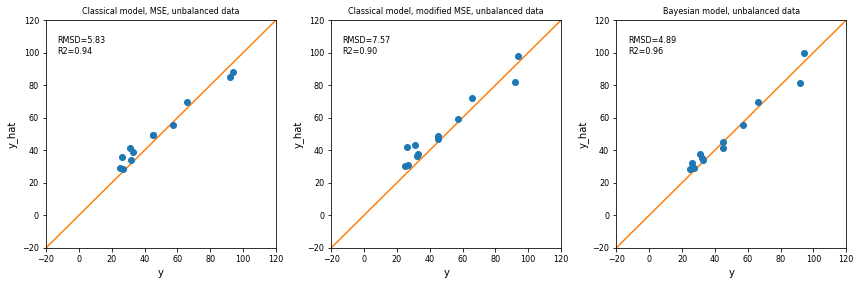

In [19]:
# predict
yhat_classical = mse_model.predict(X_test)
yhat_errors = mse_model_errors_weights.predict(X_test)
yhat_bayes = bayesian_model_weights.predict(X_test)

# calculate rmsd and r2
rmsd_classical = mean_squared_error(y_true=y_test, y_pred=yhat_classical, sample_weight=None, squared=False)
r2_classical = r2_score(y_true=y_test, y_pred=yhat_classical, sample_weight=None)

rmsd_errors = mean_squared_error(y_true=y_test, y_pred=yhat_errors, sample_weight=None, squared=False)
r2_errors = r2_score(y_true=y_test, y_pred=yhat_errors, sample_weight=None)

rmsd_bayes = mean_squared_error(y_true=y_test, y_pred=yhat_bayes, sample_weight=None, squared=False)
r2_bayes = r2_score(y_true=y_test, y_pred=yhat_bayes, sample_weight=None)

# plot the predictions
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4), sharey=False)

ax[0].errorbar(y_test.numpy(), yhat_classical, fmt="o")
ax[0].plot([0, 1], [0, 1], transform=ax[0].transAxes)
ax[0].text(x=0.05, y=0.90, s='RMSD={:.2f}'.format(rmsd_classical), transform=ax[0].transAxes)
ax[0].text(x=0.05, y=0.85, s='R2={:.2f}'.format(r2_classical), transform=ax[0].transAxes)
ax[0].set(xlabel="y",
          ylabel="y_hat",
          title="Classical model, MSE, unbalanced data",
          xlim=(-20, 120),
          ylim=(-20, 120))

ax[1].errorbar(y_test.numpy(), yhat_errors, fmt="o")
ax[1].plot([0, 1], [0, 1], transform=ax[1].transAxes)
ax[1].text(x=0.05, y=0.90, s='RMSD={:.2f}'.format(rmsd_errors), transform=ax[1].transAxes)
ax[1].text(x=0.05, y=0.85, s='R2={:.2f}'.format(r2_errors), transform=ax[1].transAxes)
ax[1].set(xlabel="y",
          ylabel="y_hat",
          title="Classical model, modified MSE, unbalanced data",
          xlim=(-20, 120),
          ylim=(-20, 120))

ax[2].errorbar(y_test.numpy(), yhat_bayes, fmt="o")
ax[2].plot([0, 1], [0, 1], transform=ax[2].transAxes)
ax[2].text(x=0.05, y=0.90, s='RMSD={:.2f}'.format(rmsd_bayes), transform=ax[2].transAxes)
ax[2].text(x=0.05, y=0.85, s='R2={:.2f}'.format(r2_bayes), transform=ax[2].transAxes)
ax[2].set(xlabel="y",
          ylabel="y_hat",
          title="Bayesian model, unbalanced data",
          xlim=(-20, 120),
          ylim=(-20, 120))

plt.tight_layout()
plt.show()

Observations: Again, the outcome depends on the dataset and learning rates, but also on how the samples are weighted. sometimes the Bayesian model being slightly worse, sometimes it's better. I'm surprised how well the classical linear model holds up. I wonder if this is a feature of my simulated data, or whether it would do equally well on real data. The Bayesian model should handle outliers better though, but I have not tested that here.